# Comparing Tree Search and Reinforcement Learning Approaches for King and Courtesan Game
## Gloire LINVANI
### CSC-52081-EP Advanced Machine Learning and Autonomous Agents Project

### The following contains adapted material from the labs 6 and 7 developed by JÃ©rÃ©mie Decock.

<img src="https://raw.githubusercontent.com/jeremiedecock/polytechnique-csc-52081-ep-2025-students/refs/heads/main/assets/logo.jpg" style="float: left; width: 15%" />

[CSC-52081-EP-2025](https://moodle.polytechnique.fr/course/view.php?id=19336)

# Requirements

This notebook relies on several libraries including `gymnasium[classic-control]` (v1.0.0), `ipywidgets`, `matplotlib`, `moviepy`, `numpy`, `pandas`, `pygame`, `seaborn`, `torch`, and `tqdm`.
A complete list of dependencies can be found in the `requirements.txt` file at the root of the repository

# Imports

In [27]:
import collections
import gymnasium as gym
import math
import itertools
import numpy as np

# from numpy.typing import NDArray
import pandas as pd
from pathlib import Path
import random
import torch
from typing import Union, List, Tuple, Optional, Callable

from numpy.f2py.auxfuncs import throw_error

In [28]:
%matplotlib inline

import matplotlib.pyplot as plt

import seaborn as sns
from tqdm.notebook import tqdm

In [29]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [30]:
sns.set_context("talk")

In [31]:
PLOTS_DIR = Path("figs/") / "RL Agents"  # Where to save plots (.png or .svg files)
MODELS_DIR = Path("models/") / "RL Agents"  # Where to save models (.pth files)

In [32]:
if not PLOTS_DIR.exists():
    PLOTS_DIR.mkdir(parents=True)
if not MODELS_DIR.exists():
    MODELS_DIR.mkdir(parents=True)

In [33]:
DEFAULT_NUMBER_OF_TRAININGS = 3

## PyTorch setup

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
# Set the device to CUDA if available, otherwise use CPU

In [35]:
print("Available GPUs:")
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"- Device {i}: {torch.cuda.get_device_name(i)}")
elif torch.backends.mps.is_available():
    print("Using Metal Performance Shaders (MPS)")
    print(f"{torch.mps.device_count()} GPU(s) available.")
else:
    print("- No GPU available.")

Available GPUs:
Using Metal Performance Shaders (MPS)
1 GPU(s) available.


In [36]:
print(f"PyTorch will train and test neural networks on {device}")

PyTorch will train and test neural networks on mps


## 1. Python King And Courtesan Environment Wrapper

In [37]:
import socket
import json
import numpy as np
import gymnasium as gym
from gymnasium import spaces


class KingAndCourtesanEnv(gym.Env):
    """
    Python wrapper for the Java King and Courtesan game environment.
    Follows Gymnasium interface and communicates with Java server via sockets.
    """

    metadata = {'render_modes': ['human']}

    def __init__(self, host='localhost', port=42, board_size=6, render_mode=None, connection_retries=3,
                 retry_delay=2.0):
        super(KingAndCourtesanEnv, self).__init__()
        self.host = host
        self.port = port
        self.board_size = board_size
        self.render_mode = render_mode
        self.connection_retries = connection_retries
        self.retry_delay = retry_delay

        # Socket connection to Java server
        self.socket = None
        self.connect_to_server()

        # Game state tracking
        self.current_player = 0  # 0 for RED, 1 for BLUE
        self.is_first_player = True  # Whether the main agent plays first
        self.legal_moves = []

        # Define action and observation spaces
        # Action space: all possible from-to position pairs
        self.action_space = spaces.Discrete(board_size * board_size * board_size * board_size)

        # Observation space: 6 channels
        # (RED_KING, RED_COURTESAN, BLUE_KING, BLUE_COURTESAN, EMPTY, CURRENT_PLAYER)
        self.observation_space = spaces.Box(
            low=0,
            high=1,
            shape=(6, board_size, board_size),
            dtype=np.float32
        )

    def connect_to_server(self):
        """Establish connection to Java server with retries"""
        for attempt in range(self.connection_retries):
            try:
                if self.socket:
                    self.socket.close()

                self.socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
                self.socket.connect((self.host, self.port))
                print(f"Connected to Java server at {self.host}:{self.port}")
                return
            except Exception as e:
                print(f"Connection attempt {attempt + 1}/{self.connection_retries} failed: {e}")
                if attempt < self.connection_retries - 1:
                    print(f"Retrying in {self.retry_delay} seconds...")
                    time.sleep(self.retry_delay)
                else:
                    print("All connection attempts failed")
                    raise

    def reset(self, seed=None, options=None):
        """Reset environment to initial state"""
        if seed is not None:
            np.random.seed(seed)

        # Randomly determine if main agent plays first (unless specified in options)
        self.is_first_player = bool(np.random.randint(0, 2)) if options is None else options.get('is_first_player',
                                                                                                 True)

        # Send reset command
        response = self._communicate({
            "command": "RESET",
            "is_first_player": self.is_first_player
        })

        # Parse state
        state = self._parse_board_state(response["board"])
        self.current_player = 0  # Reset to RED
        self.legal_moves = response["legal_moves"]

        info = {
            "legal_moves": self.legal_moves,
            "is_first_player": self.is_first_player,
            "current_player_role": "RED"
        }

        return state, info

    def step(self, action):
        """Execute action and return next state, reward, done, truncated, info"""
        # Convert action index to move string
        move = self._index_to_move(action)

        # Determine current role
        current_role = "RED" if self.current_player == 0 else "BLUE"

        # Send move command
        response = self._communicate({
            "command": "MOVE",
            "move": move,
            "role": current_role
        })

        # Check if move was valid
        if not response.get("valid_move", True):
            raise ValueError(f"Invalid move {move} attempted")
            # Instead of raising an error, we'll give a negative reward and continue
        # print(f"Warning: Invalid move {move} attempted, applying penalty")
        # return self._parse_board_state(response.get("board", [])), -1.0, False, False, {"illegal_move": True}

        # Parse new state
        next_state = self._parse_board_state(response["board"])

        # Get reward (from perspective of the agent)
        game_over = response.get("game_over", False)
        reward = 0.0

        if game_over:
            winner = response.get("winner")
            agent_role = "RED" if self.is_first_player else "BLUE"

            if winner == agent_role:
                reward = 1.0  # Win
            else:
                reward = -1.0  # Loss
        else:
            # Optional: Small reward for capturing pieces or progressing toward goal
            # This would require tracking the board state before and after the move
            pass

        # Update legal moves
        self.legal_moves = response.get("legal_moves", [])

        # Switch player
        self.current_player = 1 - self.current_player

        # Additional info
        info = {
            "legal_moves": self.legal_moves,
            "current_player_role": "BLUE" if self.current_player == 1 else "RED"
        }

        return next_state, reward, game_over, False, info

    def render(self):
        """Render the current state of the game"""
        if self.render_mode == "human":
            response = self._communicate({"command": "RENDER"})
            print(response.get("board_string", "Board render not available"))

    def get_action_mask(self):
        """
        Return a binary mask of legal actions for the current state.
        Useful for masking illegal actions in Reinforcement Learning.
        """
        mask = np.zeros(self.action_space.n, dtype=np.int8)

        # Set 1 for each legal move
        for move_str in self.legal_moves:
            action_idx = self._move_to_index(move_str)
            mask[action_idx] = 1

        return mask

    def close(self):
        """Close the environment"""
        if self.socket:
            try:
                self._communicate({"command": "CLOSE"})
                self.socket.close()
                print("Connection to Java server closed")
            except Exception as e:
                print(f"Error closing connection: {e}")
            finally:
                self.socket = None

    def _communicate(self, command):
        """Send command to Java server and receive response"""
        try:
            # Send command
            message = json.dumps(command) + "\n"
            self.socket.sendall(message.encode())

            # Receive response with better buffering
            response_data = ""
            while True:
                try:
                    # Set a timeout to avoid hanging
                    self.socket.settimeout(5.0)
                    chunk = self.socket.recv(4096).decode()

                    if not chunk:
                        break

                    response_data += chunk

                    # Check if we've received a complete JSON object
                    try:
                        json.loads(response_data)
                        break  # Successfully parsed a complete JSON object
                    except json.JSONDecodeError:
                        # Not a complete JSON object yet, continue receiving
                        continue

                except socket.timeout:
                    print("Socket timeout while waiting for response")
                    break

            # Parse JSON response
            if not response_data:
                raise ConnectionError("Received empty response from server")

            return json.loads(response_data)

        except Exception as e:
            print(f"Communication error: {e}")
            # Try to reconnect
            print("Attempting to reconnect...")
            self.connect_to_server()
            # Re-send the command after reconnection
            return self._communicate(command)

    def _parse_board_state(self, board_data):
        """Convert board data from Java to observation tensor"""
        # Initialize observation tensor (6 channels)
        observation = np.zeros((6, self.board_size, self.board_size), dtype=np.float32)

        # Fill in piece positions
        for i in range(self.board_size):
            for j in range(self.board_size):
                if i >= len(board_data) or j >= len(board_data[i]):
                    # Handle potential inconsistencies in board data
                    continue

                piece = board_data[i][j]

                if piece == "RED_KING":
                    observation[0, i, j] = 1.0
                elif piece == "RED_COURTESAN":
                    observation[1, i, j] = 1.0
                elif piece == "BLUE_KING":
                    observation[2, i, j] = 1.0
                elif piece == "BLUE_COURTESAN":
                    observation[3, i, j] = 1.0
                else:  # EMPTY
                    observation[4, i, j] = 1.0

        # Set current player channel
        observation[5, :, :] = self.current_player

        return observation

    def _index_to_move(self, action_idx):
        """Convert action index to move string (format: 'A0-B1')"""
        # Calculate board size squared
        board_sq = self.board_size * self.board_size

        # Extract source and target indices
        from_idx = action_idx // board_sq
        to_idx = action_idx % board_sq

        # Convert to coordinates
        from_row = from_idx // self.board_size
        from_col = from_idx % self.board_size
        to_row = to_idx // self.board_size
        to_col = to_idx % self.board_size

        # Convert to KingAndCourtesanMove string format
        from_pos = f"{chr(65 + from_row)}{from_col}"
        to_pos = f"{chr(65 + to_row)}{to_col}"

        return f"{from_pos}-{to_pos}"

    def _move_to_index(self, move_str):
        """Convert move string to action index"""
        # Parse move string (format: 'A0-B1')
        parts = move_str.split('-')
        from_pos = parts[0]
        to_pos = parts[1]

        # Extract coordinates
        from_row = ord(from_pos[0]) - 65
        from_col = int(from_pos[1])
        to_row = ord(to_pos[0]) - 65
        to_col = int(to_pos[1])

        # Convert to linear indices
        from_idx = from_row * self.board_size + from_col
        to_idx = to_row * self.board_size + to_col

        # Combine into single action index
        return from_idx * (self.board_size * self.board_size) + to_idx

    def sample_legal_action(self):
        """Sample a random legal action from the current state's legal moves"""
        if not self.legal_moves:
            # If no legal moves, return a random action (this shouldn't happen in a valid game)
            raise RuntimeError("No legal moves available")

        # Choose a random legal move
        move_str = np.random.choice(self.legal_moves)
        return self._move_to_index(move_str)

In [38]:
class IDAlphaBetaAgent:
    """
    Agent that utilizes the Java implemented ID Alpha-Beta algorithm to select moves.
    Communicates with a Java server running the algorithm.
    """

    def __init__(self, env, host='localhost', port=5001, timeout=40, max_retries=3):
        """
        Initialize the ID Alpha-Beta agent.

        Parameters:
        -----------
        env: KingAndCourtesanEnv
            The game environment.
        host : str
            The hostname or IP address of the Java ID Alpha-Beta server.
        port : int
            The port number of the Java ID Alpha-Beta server.
        timeout : int
            Socket timeout in seconds.
        max_retries : int
            Maximum number of connection retry attempts.
        """
        self.host = host
        self.port = port
        self.timeout = timeout
        self.max_retries = max_retries
        self.socket = None
        self.connected = self.connect()

        # Only try to reset if connected successfully
        if self.connected:
            try:
                response = self._send_command({
                    "command": "RESET_ID_ALPHA_BETA",
                    "is_first_player": env.is_first_player
                })
                print(f"ID Alpha-Beta reset response: {response}")
            except Exception as e:
                print(f"Warning: Could not initialize ID Alpha-Beta server: {e}")
                print("Will fallback to sampling legal moves when needed")

    def connect(self):
        """Establish connection to the Java ID Alpha-Beta server."""
        for attempt in range(self.max_retries):
            try:
                if self.socket:
                    self.socket.close()

                self.socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
                self.socket.settimeout(self.timeout)
                self.socket.connect((self.host, self.port))
                print(f"Connected to ID Alpha-Beta server at {self.host}:{self.port}")
                return True
            except Exception as e:
                print(f"Connection attempt {attempt + 1}/{self.max_retries} failed: {e}")
                if attempt < self.max_retries - 1:
                    print(f"Retrying in 2 seconds...")
                    time.sleep(2)
                else:
                    print("All connection attempts failed - will use random legal moves instead")
                    return False
        return False

    def select_action(self, state, env):
        """
        Select the best action for the current state using ID Alpha-Beta.

        Parameters:
        -----------
        state : numpy.ndarray
            The current state of the game.
        env : KingAndCourtesanEnv
            The game environment.

        Returns:
        --------
        int
            The action index to perform.
        """
        if not self.connected:
            # legal_move = np.random.choice(env.legal_moves)
            # action_idx = env._move_to_index(legal_move)
            # print(f"Using random legal move: {legal_move}")
            raise RuntimeError("ID Alpha-Beta agent is not connected to the server")

        try:
            # Convert state to board representation for Java
            board_json = self._state_to_board_json(state)

            # Determine current role
            current_role = "RED" if env.current_player == 0 else "BLUE"

            # Create command for Java server
            command = {
                "command": "GET_BEST_MOVE",
                "board": board_json,
                "role": current_role
            }

            # Send command and get response
            response = self._send_command(command)

            if "error" in response:
                # print(f"Error from ID Alpha-Beta server: {response['error']}")
                # Fall back to random move if there's an error
                # legal_move = np.random.choice(env.legal_moves)
                # return env._move_to_index(legal_move)
                raise RuntimeError(f"Error from ID Alpha-Beta server: {response['error']}")

            # Get best move and convert to action index
            best_move = response["best_move"]
            computation_time = response.get("computation_time_ms", 0)
            print(f"ID Alpha-Beta move: {best_move} (computed in {computation_time}ms)")

            return env._move_to_index(best_move)

        except Exception as e:
            print(f"Error in ID Alpha-Beta agent: {e}")
            raise
            # Fallback to random legal move
        # if env.legal_moves:
        #    legal_move = np.random.choice(env.legal_moves)
        #    action_idx = env._move_to_index(legal_move)
        #    print(f"Falling back to random legal move: {legal_move}")
        #    return None
        # else:
        #    print("No legal moves available, using random action")
        #    return None

    def _send_command(self, command):
        """
        Send command to Java server and receive response.

        Parameters:
        -----------
        command : dict
            The command to send.

        Returns:
        --------
        dict
            The server's response.
        """
        retries = 0

        while retries < self.max_retries:
            try:
                # Convert command to JSON and send
                command_json = json.dumps(command) + "\n"
                self.socket.sendall(command_json.encode())

                # Receive response
                response_data = ""
                while True:
                    buffer = self.socket.recv(4096).decode()
                    if not buffer:
                        break

                    response_data += buffer

                    # Try parsing to see if we have a complete JSON object
                    try:
                        json.loads(response_data)
                        # If we get here, we have a complete JSON object
                        break
                    except json.JSONDecodeError:
                        # Not a complete object yet, keep receiving
                        continue

                # Parse JSON response
                if not response_data:
                    raise ConnectionError("Received empty response from server")

                return json.loads(response_data)

            except Exception as e:
                print(f"Error in communication with ID Alpha-Beta server: {e}")
                retries += 1

                if retries < self.max_retries:
                    print(f"Retrying communication... ({retries}/{self.max_retries})")
                    # Try to reconnect
                    self.connected = self.connect()
                    time.sleep(1)
                else:
                    raise

    def _state_to_board_json(self, state):
        """
        Convert observation tensor to board JSON for Java.

        Parameters:
        -----------
        state : numpy.ndarray
            The state tensor with shape (6, board_size, board_size).

        Returns:
        --------
        list
            2D array representation of the board for JSON.
        """
        board_size = state.shape[1]  # Should be 6
        board_json = []

        for i in range(board_size):
            row = []
            for j in range(board_size):
                if state[0, i, j] == 1:
                    piece = "RED_KING"
                elif state[1, i, j] == 1:
                    piece = "RED_COURTESAN"
                elif state[2, i, j] == 1:
                    piece = "BLUE_KING"
                elif state[3, i, j] == 1:
                    piece = "BLUE_COURTESAN"
                else:
                    piece = "EMPTY"
                row.append(piece)
            board_json.append(row)

        return board_json

    def close(self):
        """Close the connection to the Java server."""
        if self.socket and self.connected:
            try:
                self._send_command({"command": "CLOSE"})
                self.socket.close()
                print("Closed connection to ID Alpha-Beta server")
            except Exception as e:
                print(f"Error closing connection: {e}")
            finally:
                self.socket = None
                self.connected = False

Print some information about the environment:

In [39]:
env = KingAndCourtesanEnv(host='localhost', port=42, render_mode='human')

# Use environment for training/testing
state, info = env.reset()
print(f"Available legal moves: {info['legal_moves']}")

# For rendering
env.render()

# Close when done
env.close()

Connected to Java server at localhost:42
Available legal moves: ['A0-A1', 'A0-B0', 'A0-B1', 'A3-B4', 'A4-A5', 'A4-B4', 'A4-B5', 'B2-C3', 'B3-B4', 'B3-C3', 'B3-C4', 'C1-D2', 'C2-C3', 'C2-D2', 'C2-D3', 'D0-E1', 'D1-D2', 'D1-E1', 'D1-E2', 'E0-E1', 'E0-F0', 'E0-F1']
  012345
F -BBBBQ
E R-BBBB
D RR-BBB
C RRR-BB
B RRRR-B
A KRRRR-
BLUE KING Position: (5,5)
RED KING Position: (0,0)
Connection to Java server closed


In [40]:
info

{'legal_moves': ['A0-A1',
  'A0-B0',
  'A0-B1',
  'A3-B4',
  'A4-A5',
  'A4-B4',
  'A4-B5',
  'B2-C3',
  'B3-B4',
  'B3-C3',
  'B3-C4',
  'C1-D2',
  'C2-C3',
  'C2-D2',
  'C2-D3',
  'D0-E1',
  'D1-D2',
  'D1-E1',
  'D1-E2',
  'E0-E1',
  'E0-F0',
  'E0-F1'],
 'is_first_player': False,
 'current_player_role': 'RED'}

#### Testing the environment with two random policies

In [41]:
env = KingAndCourtesanEnv(host='localhost', port=42, render_mode='human')

_, _ = env.reset()

for t in range(50):
    print("step", t)
    action = env.sample_legal_action()
    observation, reward, done, truncated, info = env.step(action)
    env.render()
    if done:
        print("Game Over")
        break
env.close()

Connected to Java server at localhost:42
step 0
  012345
F -BBBBQ
E RRBBBB
D R--BBB
C RRR-BB
B RRRR-B
A KRRRR-
BLUE KING Position: (5,5)
RED KING Position: (0,0)
step 1
  012345
F -BBBBQ
E RB-BBB
D R--BBB
C RRR-BB
B RRRR-B
A KRRRR-
BLUE KING Position: (5,5)
RED KING Position: (0,0)
step 2
  012345
F -BBBBQ
E RB-BBB
D R--BBB
C RRR-BB
B RRRR-R
A KRRR--
BLUE KING Position: (5,5)
RED KING Position: (0,0)
step 3
  012345
F --BBBQ
E BB-BBB
D R--BBB
C RRR-BB
B RRRR-R
A KRRR--
BLUE KING Position: (5,5)
RED KING Position: (0,0)
step 4
  012345
F --BBBQ
E BB-BBB
D R--BBB
C RRR-BR
B RRRR--
A KRRR--
BLUE KING Position: (5,5)
RED KING Position: (0,0)
step 5
  012345
F --BBBQ
E BB-BBB
D R--BB-
C RRR-BB
B RRRR--
A KRRR--
BLUE KING Position: (5,5)
RED KING Position: (0,0)
step 6
  012345
F --BBBQ
E BB-BBB
D R--BB-
C RRR-BB
B RRRR--
A RKRR--
BLUE KING Position: (5,5)
RED KING Position: (0,1)
step 7
  012345
F --BBBQ
E BB-BBB
D R--B--
C RRRBBB
B RRRR--
A RKRR--
BLUE KING Position: (5,5)
RED KING Positio

### Testing a random agent against ID Alpha-Beta agent

In [45]:
import time
def test_random_vs_alphabeta(
        env_host='localhost',
        env_port=42,
        agent_host='localhost',
        agent_port=43,
        render_mode='human',
        response_timeout=50,
        delay_between_moves=1.0,
        max_steps=50,
        verbose=True
):
    """
    Test a random agent against the ID Alpha-Beta agent in the King and Courtesan game.

    Parameters:
    -----------
    env_host : str
        Hostname for the main game environment server
    env_port : int
        Port for the main game environment server
    agent_host : str
        Hostname for the ID Alpha-Beta agent server
    agent_port : int
        Port for the ID Alpha-Beta agent server
    render_mode : str
        Render mode for the environment ('human' to display, None for no display)
    agent_timeout : int
        Timeout in seconds for the ID Alpha-Beta agent
    delay_between_moves : float
        Delay in seconds between moves for better viewing
    max_steps : int
        Maximum number of game steps
    verbose : bool
        Whether to print detailed game progress

    Returns:
    --------
    dict
        Game statistics including winner, number of steps, etc.
    """
    import time
    import numpy as np

    # Store game statistics
    stats = {
        'winner': None,
        'steps': 0,
        'random_player_role': None,
        'alphabeta_player_role': None,
        'final_reward': 0,
        'game_complete': False
    }

    # Initialize environment and agent
    env = KingAndCourtesanEnv(host=env_host, port=env_port, render_mode=render_mode)
    id_alpha_beta_agent = IDAlphaBetaAgent(env=env, host=agent_host, port=agent_port, timeout=response_timeout)

    try:
        # Reset the environment
        observation, info = env.reset()

        # Determine player roles
        if env.is_first_player:
            random_player_role = "RED"
            alphabeta_player_role = "BLUE"
            if verbose:
                print("Random agent plays first (RED)")
                print("ID Alpha-Beta agent plays second (BLUE)")
        else:
            random_player_role = "BLUE"
            alphabeta_player_role = "RED"
            if verbose:
                print("ID Alpha-Beta agent plays first (RED)")
                print("Random agent plays second (BLUE)")

        stats['random_player_role'] = random_player_role
        stats['alphabeta_player_role'] = alphabeta_player_role

        # Initialize move counter
        move_count = 0

        # First move (move 0)
        if verbose:
            print(f"Move {move_count}")

        if env.is_first_player:
            # Random agent's first move
            if verbose:
                print("Random agent's turn")
            action = env.sample_legal_action()
        else:
            # Alpha-Beta agent's first move
            if verbose:
                print("ID Alpha-Beta agent's turn")
            action = id_alpha_beta_agent.select_action(observation, env)

        # Play the first move
        observation, reward, done, truncated, info = env.step(action)
        if render_mode == 'human':
            env.render()

        move_count += 1

        # Game loop - continue with alternating turns
        while move_count < max_steps and not done:
            if verbose:
                print(f"Move {move_count}")
            stats['steps'] = move_count

            # Delay between moves if specified
            if delay_between_moves > 0:
                time.sleep(delay_between_moves)

            # Proper turn alternation - random plays when move_count%2 equals 0 if it played first
            # or when move_count%2 equals 1 if it played second
            random_turn = (move_count % 2 == 0 and env.is_first_player) or (
                        move_count % 2 == 1 and not env.is_first_player)

            if random_turn:
                # Random agent's turn
                if verbose:
                    print("Random agent's turn")
                action = env.sample_legal_action()
            else:
                # Alpha-Beta agent's turn
                if verbose:
                    print("ID Alpha-Beta agent's turn")
                action = id_alpha_beta_agent.select_action(observation, env)

            # Execute the move
            observation, reward, done, truncated, info = env.step(action)
            stats['final_reward'] = reward

            if render_mode == 'human':
                env.render()

            move_count += 1

        # Game is over
        if done:
            stats['game_complete'] = True
            if reward > 0:
                if env.is_first_player:
                    stats['winner'] = 'RED'
                else:
                    stats['winner'] = 'BLUE'
            elif reward < 0:
                if env.is_first_player:
                    stats['winner'] = 'BLUE'
                else:
                    stats['winner'] = 'RED'

            if verbose:
                print(f"Game Over! Winner: {stats['winner']}")

    except Exception as e:
        # Handle exceptions
        if verbose:
            print(f"Error during game: {e}")
        stats['error'] = str(e)

    finally:
        # Clean up resources
        env.close()
        id_alpha_beta_agent.close()

    return stats

In [47]:
result = test_random_vs_alphabeta(
    env_port=3,
    agent_port=9,
    render_mode='human',
    delay_between_moves=1.0,
    response_timeout=50,
)

print("\nGame Results:")
print(f"Winner: {result['winner']}")
print(f"Steps: {result['steps']}")
print(f"Random played as: {result['random_player_role']}")
print(f"Alpha-Beta played as: {result['alphabeta_player_role']}")

Connected to Java server at localhost:3
Connected to ID Alpha-Beta server at localhost:9
ID Alpha-Beta reset response: {'current_role': 'RED', 'ai_role': 'BLUE', 'legal_moves': ['A0-A1', 'A0-B0', 'A0-B1', 'A3-B4', 'A4-A5', 'A4-B4', 'A4-B5', 'B2-C3', 'B3-B4', 'B3-C3', 'B3-C4', 'C1-D2', 'C2-C3', 'C2-D2', 'C2-D3', 'D0-E1', 'D1-D2', 'D1-E1', 'D1-E2', 'E0-E1', 'E0-F0', 'E0-F1'], 'board': [['RED_KING', 'RED_COURTESAN', 'RED_COURTESAN', 'RED_COURTESAN', 'RED_COURTESAN', 'EMPTY'], ['RED_COURTESAN', 'RED_COURTESAN', 'RED_COURTESAN', 'RED_COURTESAN', 'EMPTY', 'BLUE_COURTESAN'], ['RED_COURTESAN', 'RED_COURTESAN', 'RED_COURTESAN', 'EMPTY', 'BLUE_COURTESAN', 'BLUE_COURTESAN'], ['RED_COURTESAN', 'RED_COURTESAN', 'EMPTY', 'BLUE_COURTESAN', 'BLUE_COURTESAN', 'BLUE_COURTESAN'], ['RED_COURTESAN', 'EMPTY', 'BLUE_COURTESAN', 'BLUE_COURTESAN', 'BLUE_COURTESAN', 'BLUE_COURTESAN'], ['EMPTY', 'BLUE_COURTESAN', 'BLUE_COURTESAN', 'BLUE_COURTESAN', 'BLUE_COURTESAN', 'BLUE_KING']]}
Random agent plays first (RED)


## 2. Deep value-based Reinforcement Learning with Deep Q-Networks (DQN)
## Deep Q-Networks v2 (DQN version 2015) with infrequent weight updates

## 2.1. The Q-network

In [49]:
import torch.nn as nn
import torch.nn.functional as F

In [50]:
class QNetwork(nn.Module):
    """Q-Network for King and Courtesan game."""

    def __init__(self, board_size=6, action_space_size=None):
        super(QNetwork, self).__init__()

        # Input: 6 channels representing the board state
        self.board_size = board_size
        if action_space_size is None:
            self.action_space_size = board_size * board_size * board_size * board_size
        else:
            self.action_space_size = action_space_size

        # Convolutional layers
        self.conv1 = nn.Conv2d(6, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Calculate the size after convolutions
        conv_output_size = 128 * board_size * board_size

        # Fully connected layers
        self.fc1 = nn.Linear(conv_output_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, self.action_space_size)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Convolutional layers with batch normalization and ReLU
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Output layer (no activation, as we want raw Q-values)
        x = self.fc3(x)

        return x

    def get_params(self) -> np.ndarray:
        """
        Get the parameters.

        Returns
        -------
        np.ndarray
            The parameters of the model.
        """
        return self.params.copy()

    def set_params(self, params: np.ndarray) -> None:
        """
        Set the parameters.

        Parameters
        ----------
        params : np.ndarray
            The parameters of the model.
        """
        self.params = params.copy()

### 2.1.1 Inference Function

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time

def test_q_network_in_king_courtesan(device=None, num_episodes=5, render=True, board_size=6):
    """
    Test Q-Network agent against another Q-Network in the King and Courtesan environment.

    Parameters:
    -----------
    device : torch.device
        Device to run the networks on (CPU or GPU)
    num_episodes : int
        Number of episodes to run
    render : bool
        Whether to render the environment
    board_size : int
        Size of the game board

    Returns:
    --------
    list
        List of episode rewards
    """
    # Import necessary modules
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import numpy as np

    # Set device
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize environment
    env = KingAndCourtesanEnv(
        host='localhost',
        port=42,
        board_size=board_size,
        render_mode='human' if render else None
    )

    # Initialize Q-Networks
    q_network = QNetwork(board_size=board_size).to(device)
    q_network_adversary = QNetwork(board_size=board_size).to(device)

    # Modify test_q_network_agent to use env.legal_moves instead of env.get_legal_moves()
    def modified_test_q_network_agent(env, q_network, q_network_adversary, num_episode=1):
        """Test Q-Network agents in the environment."""
        episode_reward_list = []

        for episode_id in range(num_episode):
            state, info = env.reset()
            done = False
            episode_reward = 0.0

            # Initial player is RED (0)
            current_player = 0
            current_network = q_network if current_player == 0 else q_network_adversary

            move_count = 0
            while not done:
                move_count += 1
                print(f"Move {move_count}, Player: {'RED' if current_player == 0 else 'BLUE'}")

                # Get legal moves
                legal_moves = env.legal_moves  # Using the attribute instead of method

                # Convert state to tensor for neural network
                state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

                # Get Q-values
                q_values = current_network(state_tensor)

                # Create legal moves mask
                mask = torch.ones_like(q_values) * float('-inf')
                for move in legal_moves:
                    move_idx = env._move_to_index(move)
                    mask[0, move_idx] = 0

                # Apply mask and get best legal action
                masked_q_values = q_values + mask
                action = masked_q_values.argmax(dim=1).item()

                # Print the selected move
                selected_move = env._index_to_move(action)
                print(f"Selected move: {selected_move}")

                # Take step in environment
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                # Update total reward (from perspective of the main agent)
                if current_player == 0:  # Main agent's turn
                    episode_reward += reward

                # Prepare for next step
                state = next_state
                current_player = 1 - current_player
                current_network = q_network if current_player == 0 else q_network_adversary

                # Add a delay to make the game visible
                if render:
                    time.sleep(1.0)

            episode_reward_list.append(episode_reward)
            print(f"Episode {episode_id+1} reward: {episode_reward}")

        return episode_reward_list

    # Run the test
    try:
        print("Starting Q-Network vs Q-Network test...")
        print(f"Board size: {board_size}x{board_size}")
        print(f"Device: {device}")

        rewards = modified_test_q_network_agent(
            env=env,
            q_network=q_network,
            q_network_adversary=q_network_adversary,
            num_episode=num_episodes
        )

        # Print summary
        print("\nTest Results Summary:")
        print(f"Episodes played: {num_episodes}")
        print(f"Average reward: {np.mean(rewards):.2f}")
        print(f"Rewards per episode: {rewards}")

        return rewards

    finally:
        # Clean up
        env.close()

In [ ]:

# Example usage
if __name__ == "__main__":
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Run the test
    rewards = test_q_network_in_king_courtesan(
        device=device,
        num_episodes=3,
        render=True
    )

Testing this function on the untrained agent.

In [25]:
dqnv2 = QNetwork(observation_dim, num_actions, nn_l1=128, nn_l2=128).to(device)

In [26]:
NUM_EPISODES = 3

env =

test_q_network_agent(env, dqnv2, num_episode=NUM_EPISODES)

env.close()

Episode reward: 9.0
Episode reward: 8.0
Episode reward: 9.0

Select the episode to play here ðŸ‘‡



interactive(children=(Dropdown(description='file_path', options=(PosixPath('figs/lab6/lab6_ex2_dqn_naive_untaiâ€¦

<function __main__.video_selector(file_path: List[pathlib.Path])>

Copy and paste the output of the following cell into the first question of the [Lab 6 - Evaluation](https://moodle.polytechnique.fr/course/section.php?id=66534) in Moodle:
*"What is the total number of parameters in the Q-Network constructed in the second exercise?"*

### Epsilon Greedy Function

In [28]:
class EpsilonGreedy:
    """
    An Epsilon-Greedy policy.

    Attributes
    ----------
    epsilon : float
        The initial probability of choosing a random action.
    epsilon_min : float
        The minimum probability of choosing a random action.
    epsilon_decay : float
        The decay rate for the epsilon value after each action.
    env : gym.Env
        The environment in which the agent is acting.
    q_network : torch.nn.Module
        The Q-Network used to estimate action values.

    Methods
    -------
    __call__(state: np.ndarray) -> np.int64
        Select an action for the given state using the epsilon-greedy policy.
    decay_epsilon()
        Decay the epsilon value after each action.
    """

    def __init__(
            self,
            epsilon_start: float,
            epsilon_min: float,
            epsilon_decay: float,
            env: gym.Env,
            q_network: torch.nn.Module,
    ):
        """
        Initialize a new instance of EpsilonGreedy.

        Parameters
        ----------
        epsilon_start : float
            The initial probability of choosing a random action.
        epsilon_min : float
            The minimum probability of choosing a random action.
        epsilon_decay : float
            The decay rate for the epsilon value after each episode.
        env : gym.Env
            The environment in which the agent is acting.
        q_network : torch.nn.Module
            The Q-Network used to estimate action values.
        """
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.env = env
        self.q_network = q_network

    def __call__(self, state: np.ndarray) -> np.int64:
        """
        Select an action for the given state using the epsilon-greedy policy.

        If a randomly chosen number is less than epsilon, a random action is chosen.
        Otherwise, the action with the highest estimated action value is chosen.

        Parameters
        ----------
        state : np.ndarray
            The current state of the environment.

        Returns
        -------
        np.int64
            The chosen action.
        """

        if random.random() < self.epsilon:
            action = int(self.env.action_space.sample())
        else:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

                q_values = self.q_network(state_tensor)

                action = q_values.argmax(dim=1).squeeze().item()

        return action

    def decay_epsilon(self):
        """
        Decay the epsilon value after each episode.

        The new epsilon value is the maximum of `epsilon_min` and the product of the current
        epsilon value and `epsilon_decay`.
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

### Learning Rate Scheduler

In [29]:
class MinimumExponentialLR(torch.optim.lr_scheduler.ExponentialLR):
    def __init__(
            self,
            optimizer: torch.optim.Optimizer,
            lr_decay: float,
            last_epoch: int = -1,
            min_lr: float = 1e-6,
    ):
        """
        Initialize a new instance of MinimumExponentialLR.

        Parameters
        ----------
        optimizer : torch.optim.Optimizer
            The optimizer whose learning rate should be scheduled.
        lr_decay : float
            The multiplicative factor of learning rate decay.
        last_epoch : int, optional
            The index of the last epoch. Default is -1.
        min_lr : float, optional
            The minimum learning rate. Default is 1e-6.
        """
        self.min_lr = min_lr
        super().__init__(optimizer, lr_decay, last_epoch=-1)

    def get_lr(self) -> List[float]:
        """
        Compute learning rate using chainable form of the scheduler.

        Returns
        -------
        List[float]
            The learning rates of each parameter group.
        """
        return [
            max(base_lr * self.gamma ** self.last_epoch, self.min_lr)
            for base_lr in self.base_lrs
        ]

### 2.1.2. Training Function

To compute the target value, we can eliminate the need for an if statement to differentiate between terminal and non-terminal states by using the following formula:

$$
y = r + \gamma \max_{\mathbf{a}^\star \in \mathcal{A}} \hat{Q}_{\mathbf{\omega}}(\mathbf{s'})_{\mathbf{a}^\star} \times (1 - \text{done})
$$

where $\text{done} = 1$ if $s'$ is a terminal state and 0 otherwise.

### Replay Buffer

Memory buffer where experiences are stored. We sample a random batch of experiences from this buffer to update the weights.

In [36]:
class ReplayBuffer:
    """
    A Replay Buffer.

    Attributes
    ----------
    buffer : collections.deque
        A double-ended queue where the transitions are stored.

    Methods
    -------
    add(state: np.ndarray, action: np.int64, reward: float, next_state: np.ndarray, done: bool)
        Add a new transition to the buffer.
    sample(batch_size: int) -> Tuple[np.ndarray, float, float, np.ndarray, bool]
        Sample a batch of transitions from the buffer.
    __len__()
        Return the current size of the buffer.
    """

    def __init__(self, capacity: int):
        """
        Initializes a ReplayBuffer instance.

        Parameters
        ----------
        capacity : int
            The maximum number of transitions that can be stored in the buffer.
        """
        self.buffer: collections.deque = collections.deque(maxlen=capacity)

    def add(
            self,
            state: np.ndarray,
            action: np.int64,
            reward: float,
            next_state: np.ndarray,
            done: bool,
    ):
        """
        Add a new transition to the buffer.

        Parameters
        ----------
        state : np.ndarray
            The state vector of the added transition.
        action : np.int64
            The action of the added transition.
        reward : float
            The reward of the added transition.
        next_state : np.ndarray
            The next state vector of the added transition.
        done : bool
            The final state of the added transition.
        """
        self.buffer.append((state, action, reward, next_state, done))

    def sample(
            self, batch_size: int
    ) -> Tuple[np.ndarray, Tuple[int], Tuple[float], np.ndarray, Tuple[bool]]:
        """
        Sample a batch of transitions from the buffer.

        Parameters
        ----------
        batch_size : int
            The number of transitions to sample.

        Returns
        -------
        Tuple[np.ndarray, float, float, np.ndarray, bool]
            A batch of `batch_size` transitions.
        """
        # Here, `random.sample(self.buffer, batch_size)`
        # returns a list of tuples `(state, action, reward, next_state, done)`
        # where:
        # - `state`  and `next_state` are numpy arrays
        # - `action` and `reward` are floats
        # - `done` is a boolean
        #
        # `states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))`
        # generates 5 tuples `state`, `action`, `reward`, `next_state` and `done`, each having `batch_size` elements.
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.array(states), actions, rewards, np.array(next_states), dones

    def __len__(self):
        """
        Return the current size of the buffer.

        Returns
        -------
        int
            The current size of the buffer.
        """
        return len(self.buffer)

In 2015, DeepMind further advanced the field of reinforcement learning with the publication of the paper "Human-level control through deep reinforcement learning" by Volodymyr Mnih and colleagues (https://www.nature.com/articles/nature14236). This work introduced the second version of Deep Q-Networks (DQN).

<img src="https://raw.githubusercontent.com/jeremiedecock/polytechnique-csc-52081-ep-2025-students/main/assets/lab6_dqn_nature_journal.jpg" width="200px" />

The key contribution of this paper was the introduction of a method to stabilize the learning process by infrequently updating the target weights. This technique, known as *infrequent updates of target weights*, significantly improved the stability of the learning process.

#### Infrequent weight updates

Infrequent weight updates, also known as the use of a target network, is a technique used in Deep Q-Networks (DQN) to address the issue of learning from a moving target.

In a typical DQN setup, there are two neural networks: the Q-network and the target network. The Q-network is used to predict the Q-values and is updated at every time step. The target network is used to compute the target Q-values for the update, and its weights are updated less frequently, typically every few thousand steps, by copying the weights from the Q-network.

The idea behind infrequent weight updates is to stabilize the learning process by keeping the target Q-values fixed for a number of steps. This mitigates the issue of learning from a moving target, as the target Q-values remain fixed between updates.

Without infrequent weight updates, both the predicted and target Q-values would change at every step, which could lead to oscillations and divergence in the learning process. By introducing a delay between updates of the target Q-values, the risk of such oscillations is reduced.

#### DQN v2015 Algorithm

Note: main differences with the previous algorithm are highlighted in red.

<b>Input</b>:<br>
	$\quad\quad$ none<br>
<b>Algorithm parameter</b>:<br>
	$\quad\quad$ discount factor $\gamma$<br>
	$\quad\quad$ step size $\alpha \in (0,1]$<br>
	$\quad\quad$ small $\epsilon > 0$<br>
	$\quad\quad$ capacity of the experience replay memory $M$<br>
	$\quad\quad$ batch size $m$<br>
	$\quad\quad$ target network update frequency $\color{red}{\tau}$<br><br>

<b>Initialize</b> replay memory $\mathcal{D}$ to capacity $M$<br>
<b>Initialize</b> action-value function $\hat{Q}_{\mathbf{\omega_1}}$ with random weights $\mathbf{\omega_1}$<br>
<b>Initialize</b> target action-value function $\hat{Q}_{\mathbf{\omega_2}}$ with weights $\color{red}{\mathbf{\omega_2} = \mathbf{\omega_1}}$<br><br>

<b>FOR EACH</b> episode<br>
	$\quad$ $\mathbf{s} \leftarrow \text{env.reset}()$<br>
	$\quad$ <b>DO</b> <br>
		$\quad\quad$ $\mathbf{a} \leftarrow \epsilon\text{-greedy}(\mathbf{s}, \hat{Q}_{\mathbf{\omega_1}})$<br>
		$\quad\quad$ $r, \mathbf{s'} \leftarrow \text{env.step}(\mathbf{a})$<br>
		$\quad\quad$ Store transition $(\mathbf{s}, \mathbf{a}, r, \mathbf{s'})$ in $\mathcal{D}$<br>
		$\quad\quad$ If $\mathcal{D}$ contains "enough" transitions<br>
			$\quad\quad\quad$ Sample random batch of transitions $(\mathbf{s}_j, \mathbf{a}_j, r_j, \mathbf{s'}_j)$ from $\mathcal{D}$ with $j=1$ to $m$<br>
			$\quad\quad\quad$ For each $j$, set $y_j =
			\begin{cases}
			r_j & \text{for terminal } \mathbf{s'}_j\\
			r_j + \gamma \max_{\mathbf{a}^\star} \hat{Q}_{\mathbf{\omega_{\color{red}{2}}}} (\mathbf{s'}_j)_{\mathbf{a}^\star} & \text{for non-terminal } \mathbf{s'}_j
			\end{cases}$<br>
			$\quad\quad\quad$ Perform a gradient descent step on $\left( y_j - \hat{Q}_{\mathbf{\omega_1}}(\mathbf{s}_j)_{\mathbf{a}_j} \right)^2$ with respect to the weights $\mathbf{\omega_1}$<br>
			$\quad\quad\quad$ Every $\color{red}{\tau}$ steps reset $\hat{Q}_{\mathbf{\omega_2}}$ to $\hat{Q}_{\mathbf{\omega_1}}$, i.e., set $\color{red}{\mathbf{\omega_2} \leftarrow \mathbf{\omega_1}}$<br>
		$\quad\quad$ $\mathbf{s} \leftarrow \mathbf{s'}$ <br>
	$\quad$ <b>UNTIL</b> $\mathbf{s}$ is final<br><br>
<b>RETURN</b> $\mathbf{\omega_1}$ <br>


Infrequent weight updates in the training function:

1. **Update the Target Network Infrequently**: Instead of updating the weights of the target network at every time step, update them less frequently, for example, every few thousand steps. The weights of the target network are updated by copying the weights from the Q-network.

2. **Compute Target Q-values with the Target Network**: When computing the target Q-values for the update, use the target network instead of the Q-network. This ensures that the target Q-values remain fixed between updates, which stabilizes the learning process.

In [46]:
def train_dqn2_agent(
        env: gym.Env,
        q_network: torch.nn.Module,
        q_network_adversary: torch.nn.Module,
        target_q_network: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        loss_fn: Callable,
        epsilon_greedy: EpsilonGreedy,
        device: torch.device,
        lr_scheduler: torch.optim.lr_scheduler.LRScheduler,
        num_episodes: int,
        gamma: float,
        batch_size: int,
        replay_buffer: ReplayBuffer,
        target_q_network_sync_period: int,
) -> List[float]:
    """
    Train the Q-network on the given environment.

    Parameters
    ----------
    env : gym.Env
        The environment to train on.
    q_network : torch.nn.Module
        The Q-network to train.
    q_network_adversary : torch.nn.Module
        The Q-network of the adversary.
    target_q_network : torch.nn.Module
        The target Q-network to use for estimating the target Q-values.
    optimizer : torch.optim.Optimizer
        The optimizer to use for training.
    loss_fn : callable
        The loss function to use for training.
    epsilon_greedy : EpsilonGreedy
        The epsilon-greedy policy to use for action selection.
    device : torch.device
        The device to use for PyTorch computations.
    lr_scheduler : torch.optim.lr_scheduler.LRScheduler
        The learning rate scheduler to adjust the learning rate during training.
    num_episodes : int
        The number of episodes to train for.
    gamma : float
        The discount factor for future rewards.
    batch_size : int
        The size of the batch to use for training.
    replay_buffer : ReplayBuffer
        The replay buffer storing the experiences with their priorities.
    target_q_network_sync_period : int
        The number of episodes after which the target Q-network should be updated with the weights of the Q-network.

    Returns
    -------
    List[float]
        A list of cumulated rewards per episode.
    """
    iteration = 0
    episode_reward_list = []

    for episode_index in tqdm(range(1, num_episodes)):
        state = env.reset()
        episode_reward = 0.0

        for t in itertools.count():
            # Get action, next_state and reward

            action = epsilon_greedy(state)

            next_state, reward, terminated, truncated = env.step(action)
            done = terminated or truncated

            replay_buffer.add(state, action, float(reward), next_state, done)

            episode_reward += float(reward)

            # Update the q_network weights with a batch of experiences from the buffer

            if len(replay_buffer) > batch_size:
                batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = replay_buffer.sample(
                    batch_size)

                # Convert to PyTorch tensors
                batch_states_tensor = torch.tensor(batch_states, dtype=torch.float32, device=device)
                batch_actions_tensor = torch.tensor(batch_actions, dtype=torch.long, device=device)
                batch_rewards_tensor = torch.tensor(batch_rewards, dtype=torch.float32, device=device)
                batch_next_states_tensor = torch.tensor(batch_next_states, dtype=torch.float32, device=device)
                batch_dones_tensor = torch.tensor(batch_dones, dtype=torch.float32, device=device)

                # Compute the target Q values for the batch
                with torch.no_grad():
                    next_state_q_values = target_q_network(batch_next_states_tensor)
                    best_next_q_values = next_state_q_values.max(1)[0]

                    targets = batch_rewards_tensor + gamma * best_next_q_values * (1 - batch_dones_tensor)

                current_q_values = q_network(batch_states_tensor)
                current_q_values = current_q_values.gather(1, batch_actions_tensor.unsqueeze(1)).squeeze(1)

                # Compute loss
                loss = loss_fn(current_q_values, targets)

                # Optimize the model
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                lr_scheduler.step()

            # Update the target q-network weights

            iteration += 1

            if iteration % target_q_network_sync_period == 0:
                target_q_network.load_state_dict(q_network.state_dict())

            if done:
                break

            state = next_state

        episode_reward_list.append(episode_reward)
        epsilon_greedy.decay_epsilon()

    return episode_reward_list

### Training

We need to instantiate and initialize the two neural networks.

A target network that has the same architecture as the Q-network. The weights of the target network are initially copied from the Q-network.

In [47]:
env =

NUMBER_OF_TRAININGS = DEFAULT_NUMBER_OF_TRAININGS
dqn2_trains_result_list: List[List[Union[int, float]]] = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):
    # Instantiate required objects

    dqnv2 = QNetwork(observation_dim, num_actions, nn_l1=128, nn_l2=128).to(device)
    q_network_adversary = QNetwork(observation_dim, num_actions, nn_l1=128, nn_l2=128).to(device)

    target_q_network = QNetwork(observation_dim, num_actions, nn_l1=128, nn_l2=128).to(device)

    target_q_network.load_state_dict(dqnv2.state_dict())

    optimizer = torch.optim.AdamW(dqnv2.parameters(), lr=0.004, amsgrad=True)
    # lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
    loss_fn = torch.nn.MSELoss()

    epsilon_greedy = EpsilonGreedy(
        epsilon_start=0.82,
        epsilon_min=0.013,
        epsilon_decay=0.9675,
        env=env,
        q_network=dqnv2,
    )

    replay_buffer = ReplayBuffer(2000)

    # Train the q-network

    episode_reward_list = train_dqn2_agent(
        env,
        dqnv2,
        q_network_adversary,
        target_q_network,
        optimizer,
        loss_fn,
        epsilon_greedy,
        device,
        lr_scheduler,
        num_episodes=150,
        gamma=0.9,
        batch_size=128,
        replay_buffer=replay_buffer,
        target_q_network_sync_period=30,
    )
    dqn2_trains_result_list[0].extend(range(len(episode_reward_list)))
    dqn2_trains_result_list[1].extend(episode_reward_list)
    dqn2_trains_result_list[2].extend([train_index for _ in episode_reward_list])

dqn2_trains_result_df = pd.DataFrame(
    np.array(dqn2_trains_result_list).T,
    columns=["num_episodes", "mean_final_episode_reward", "training_index"],
)
dqn2_trains_result_df["agent"] = "DQN 2015"

# Save the action-value estimation function

torch.save(dqnv2, MODELS_DIR / "dqn2_q_network.pth")

env.close()

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

#### Plots

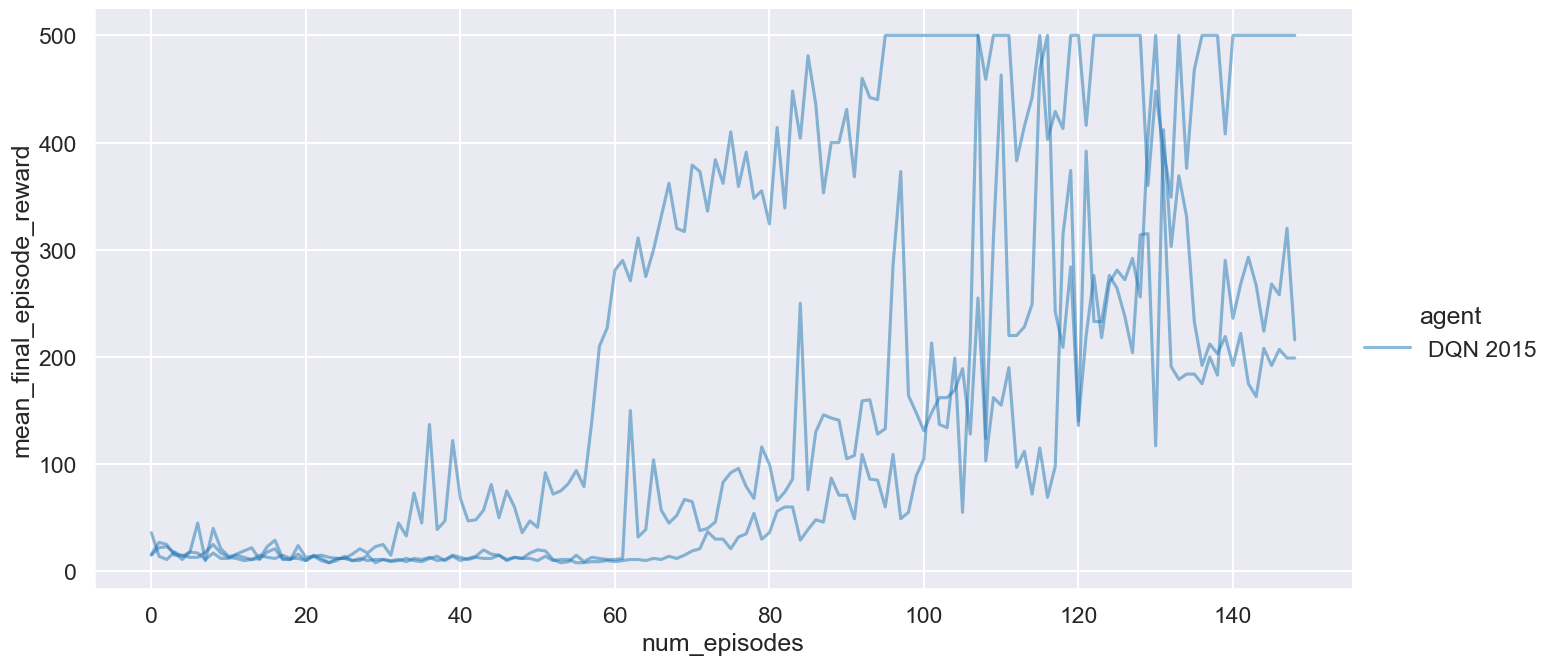

In [53]:
g = sns.relplot(
    x="num_episodes",
    y="mean_final_episode_reward",
    kind="line",
    hue="agent",
    estimator=None,
    units="training_index",
    data=dqn2_trains_result_df,
    height=7,
    aspect=2,
    alpha=0.5,
)
plt.savefig(PLOTS_DIR / "dqnv2_trains_results.png")
plt.show()

### Testing Against a Random Policy

In [ ]:
NUM_EPISODES = 3

env =

test_q_network_agent(env, dqnv2, q_network_adversary, num_episode=NUM_EPISODES)

env.close()

### Testing Against our Java ID Alpha Beta Agent

In [51]:
NUM_EPISODES = 3

env =

test_q_network_agent(env, dqnv2, num_episode=NUM_EPISODES)

env.close()

Episode reward: 185.0
Episode reward: 206.0
Episode reward: 207.0

Select the episode to play here ðŸ‘‡



interactive(children=(Dropdown(description='file_path', options=(PosixPath('figs/lab6/lab6_ex4_dqn2_tained-epiâ€¦

#### Score

In [52]:
train_score_dqn2 = dqn2_trains_result_df[["num_episodes", "mean_final_episode_reward"]].groupby(
    "num_episodes").mean().max()
train_score_dqn2

mean_final_episode_reward    418.333333
dtype: float64

## 3. Deep policy-based Reinforcement Learning with Monte Carlo Policy Gradient (REINFORCE)

### The Policy Gradient theorem

This is a policy gradient method that directly searchs in a family of parameterized policies $\pi_\theta$ for the optimal policy.

This method performs gradient ascent in the policy space so that the total return is maximized.
We will restrict our work to episodic tasks, *i.e.* tasks that have a starting states and last for a finite and fixed number of steps $T$, called horizon.

More formally, we define an optimization criterion that we want to maximize:

$$J(\theta) = \mathbb{E}_{\pi_\theta}\left[\sum_{t=1}^T r(s_t,a_t)\right],$$

where $\mathbb{E}_{\pi_\theta}$ means $a \sim \pi_\theta(\cdot|s)$ and $T$ is the horizon of the episode.
In other words, we want to maximize the value of the starting state: $V^{\pi_\theta}(s)$.
The policy gradient theorem tells us that:

$$
\nabla_\theta J(\theta) = \nabla_\theta V^{\pi_\theta}(s) = \mathbb{E}_{\pi_\theta} \left[\nabla_\theta \log \pi_\theta (a|s) ~ Q^{\pi_\theta}(s,a) \right],
$$

where the $Q$-function is defined as:

$$Q^{\pi_\theta}(a|s) = \mathbb{E}^{\pi_\theta} \left[\sum_{t=1}^T r(s_t,a_t)|s=s_1, a=a_1\right].$$

The policy gradient theorem is particularly effective because it allows gradient computation without needing to understand the system's dynamics, as long as the $Q$-function for the current policy is computable. By simply applying the policy and observing the one-step transitions, sufficient information is gathered. Implementing a stochastic gradient ascent and substituting $Q^{\pi_\theta}(s_t,a_t)$ with a Monte Carlo estimate $R_t = \sum_{t'=t}^T r(s_{t'},a_{t'})$ for a single trajectory, we derive the REINFORCE algorithm.

The REINFORCE algorithm, introduced by Williams in 1992, is a Monte Carlo policy gradient method. It updates the policy in the direction that maximizes rewards, using full-episode returns as an unbiased estimate of the gradient. Each step involves generating an episode using the current policy, computing the gradient estimate, and updating the policy parameters. This algorithm is simple yet powerful, and it's particularly effective in environments where the policy gradient is noisy or the dynamics are complex.

For further reading and a deeper understanding, refer to Williams' seminal paper (https://link.springer.com/article/10.1007/BF00992696) and the comprehensive text on reinforcement learning by Richard S. Sutton and Andrew G. Barto: "Reinforcement Learning: An Introduction", chap.13 (http://incompleteideas.net/book/RLbook2020.pdf).

Here is the REINFORCE algorithm.

### Monte Carlo policy gradient (REINFORCE)

<b>REQUIRE</b> <br>
$\quad$ A differentiable policy $\pi_{\boldsymbol{\theta}}$ <br>
$\quad$ A learning rate $\alpha \in \mathbb{R}^+$ <br>
<b>INITIALIZATION</b> <br>
$\quad$ Initialize parameters $\boldsymbol{\theta} \in \mathbb{R}^d$ <br>
<br>
<b>FOR EACH</b> episode <br>
$\quad$ Generate full trace $\tau = \{ \boldsymbol{s}_0, \boldsymbol{a}_0, r_1, \boldsymbol{s}_1, \boldsymbol{a}_1, \dots, r_T, \boldsymbol{s}_T \}$ following $\pi_{\boldsymbol{\theta}}$ <br>
$\quad$ <b>FOR</b> $~ t=0,\dots,T-1$ <br>
$\quad\quad$ $G \leftarrow \sum_{k=t}^{T-1} r_k$ <br>
$\quad\quad$ $\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} + \alpha ~ \underbrace{G ~ \nabla_{\boldsymbol{\theta}} \ln \pi_{\boldsymbol{\theta}}(\boldsymbol{a}_t|\boldsymbol{s}_t)}_{\nabla_{\boldsymbol{\theta}} J(\boldsymbol{\theta})}$ <br>
<br>
<b>RETURN</b> $\boldsymbol{\theta}$

### 3.1 Policy Implementation

We will implement a stochastic policy to control the agent's actions.

The network takes an input tensor representing the state of the environment and outputs a tensor of action probabilities.

In [ ]:
class PolicyNetwork(torch.nn.Module):
    """
    A neural network used as a policy for the REINFORCE algorithm.

    Attributes
    ----------
    layer1 : torch.nn.Linear
        A fully connected layer.

    Methods
    -------
    forward(state: torch.Tensor) -> torch.Tensor
        Define the forward pass of the PolicyNetwork.
    """

    def __init__(self, n_observations: int, n_actions: int):
        """
        Initialize a new instance of PolicyNetwork.

        Parameters
        ----------
        n_observations : int
            The size of the observation space.
        n_actions : int
            The size of the action space.
        """
        super(PolicyNetwork, self).__init__()

        # TODO...

    def forward(self, state_tensor: torch.Tensor) -> torch.Tensor:
        """
        Calculate the probability of each action for the given state.

        Parameters
        ----------
        state_tensor : torch.Tensor
            The input tensor (state).
            The shape of the tensor should be (N, dim),
            where N is the number of states vectors in the batch
            and dim is the dimension of state vectors.

        Returns
        -------
        torch.Tensor
            The output tensor (the probability of each action for the given state).
        """

        # TODO...

        return out

    def get_params(self) -> np.ndarray:
        """
        Get the parameters.

        Returns
        -------
        np.ndarray
            The parameters of the model.
        """
        return self.params.copy()

    def set_params(self, params: np.ndarray) -> None:
        """
        Set the parameters.

        Parameters
        ----------
        params : np.ndarray
            The parameters of the model.
        """
        self.params = params.copy()

`sample_discrete_action` function: This function is used to sample a discrete action based on a given state and a policy network. It first converts the state into a tensor if not already one and passes it through the policy network to get the parameters of the action probability distribution. Then, it creates a categorical distribution from these parameters and samples an action from this distribution. It also calculates the log probability of the sampled action according to the distribution. The function returns the sampled action and its log probability.

In [ ]:
def sample_discrete_action(
        policy_nn: PolicyNetwork, state: np.ndarray
) -> Tuple[int, torch.Tensor]:
    """
    Sample a discrete action based on the given state and policy network.

    This function takes a state and a policy network, and returns a sampled action and its log probability.
    The action is sampled from a categorical distribution defined by the output of the policy network.

    Parameters
    ----------
    policy_nn : PolicyNetwork
        The policy network that defines the probability distribution of the actions.
    state : np.ndarray
        The state based on which an action needs to be sampled.

    Returns
    -------
    Tuple[int, torch.Tensor]
        The sampled action and its log probability.

    """

    # Convert the state into a tensor, specify its data type as float32, and send it to the device (CPU or GPU).
    # The unsqueeze(0) function is used to add an extra dimension to the tensor to match the input shape required by the policy network.
    # state_tensor = TODO...

    # Pass the state tensor through the policy network to get the parameters of the action probability distribution.
    # actions_probability_distribution_params = TODO...

    # Create the categorical distribution used to sample an action from the parameters obtained from the policy network.
    # See https://pytorch.org/docs/stable/distributions.html#categorical
    # actions_probability_distribution = TODO...

    # Sample an action from the categorical distribution.
    # sampled_action_tensor = TODO...

    # Convert the tensor containing the sampled action into a Python integer.
    # sampled_action = TODO...

    # Calculate the log probability of the sampled action according to the categorical distribution.
    # sampled_action_log_probability = TODO...

    # Return the sampled action and its log probability.
    return sampled_action, sampled_action_log_probability

Testing the `sample_discrete_action` function on a random state using an untrained policy network.

In [ ]:
env =

# policy_nn = TODO...

# state = TODO...
# theta = TODO...
# action, action_log_probability = TODO...

print("state:", state)
print("theta:", theta)
print("sampled action:", action)
print("log probability of the sampled action:", action_log_probability)

env.close()

#### sample_one_episode function

This function plays one episode using the given policy $\pi_\theta$ and return its rollouts. The function adheres to a fixed horizon $T$, which represents the maximum number of steps in the episode.

In [ ]:
def sample_one_episode(
        env: gym.Env, policy_nn: PolicyNetwork, max_episode_duration: int
) -> Tuple[List[np.ndarray], List[int], List[float], List[torch.Tensor]]:
    """
    Execute one episode within the `env` environment utilizing the policy defined by the `policy_nn` parameter.

    Parameters
    ----------
    env : gym.Env
        The environment to play in.
    policy_nn : PolicyNetwork
        The policy neural network.
    policy_nn_adversary : PolicyNetwork
        The adversary policy neural network.
    max_episode_duration : int
        The maximum duration of the episode.

    Returns
    -------
    Tuple[List[np.ndarray], List[int], List[float], List[torch.Tensor]]
        The states, actions, rewards, and log probability of action for each time step in the episode.
    """
    state_t = env.reset()

    episode_states = []
    episode_actions = []
    episode_log_prob_actions = []
    episode_rewards = []
    episode_states.append(state_t)

    for t in range(max_episode_duration):

        # Sample a discrete action and its log probability from the policy network based on the current state
        # action_t, log_prob_action_t = TODO...

        # Execute the sampled action in the environment, which returns the new state, reward, and whether the episode has terminated or been truncated
        # state_t, reward_t, terminated, truncated = TODO...

        # Check if the episode is done, either due to termination (reaching a terminal state) or truncation (reaching a maximum number of steps)
        done = terminated or truncated

        # Append the new state, action, action log probability and reward to their respective lists

        episode_states.append(state_t)
        episode_actions.append(action_t)
        episode_log_prob_actions.append(log_prob_action_t)
        episode_rewards.append(float(reward_t))

        if done:
            break

    return episode_states, episode_actions, episode_rewards, episode_log_prob_actions

Testing this function on the untrained agent.

In [ ]:
NUM_EPISODES = 3

env =

for episode_index in range(NUM_EPISODES):
# policy_nn = TODO...
# policy_nn_adversary = TODO...
# episode_states, episode_actions, episode_rewards, episode_log_prob_actions = TODO...

env.close()

In [ ]:
episode_states

In [ ]:
episode_actions

In [ ]:
episode_rewards

#### Test Function

`avg_return_on_multiple_episodes` function tests the given policy $\pi_\theta$ on `num_episodes` episodes (for fixed horizon $T$) and returns the average reward on the `num_episodes` episodes.

The function `avg_return_on_multiple_episodes` is designed to play multiple episodes of a given environment using a specified policy neural network and calculate the average return. It takes as input the environment to play in, the policy neural networks to use, the number of episodes to play and the maximum duration of an episode.
In each episode, it uses the `sample_one_episode` function to play the episode and collect the rewards. The function then returns the average of these cumulated rewards.

`avg_return_on_multiple_episodes` will be used for evaluating the performance of a policy over multiple episodes.

In [ ]:
def avg_return_on_multiple_episodes(
        env: gym.Env,
        policy_nn: PolicyNetwork,
        policy_nn_adversary: PolicyNetwork,
        num_test_episode: int,
        max_episode_duration: int,
) -> float:
    """
    Play multiple episodes of the environment and calculate the average return.

    Parameters
    ----------
    env : gym.Env
        The environment to play in.
    policy_nn : PolicyNetwork
        The policy neural network.
    plocy_nn_adversary : PolicyNetwork
        The adversary policy neural network.
    num_test_episode : int
        The number of episodes to play.
    max_episode_duration : int
        The maximum duration of an episode.

    Returns
    -------
    float
        The average return.
    """

    # TODO...

    return average_return

Testing this function on the untrained agent.

In [ ]:
env =

# TODO...

print(average_return)

env.close()

### 3.2 Train Function

`train_reinforce_discrete` trains a policy network using the REINFORCE algorithm in the given environment. This function takes as input the environment, the number of training episodes, the number of tests to perform per episode, the maximum duration of an episode, and the learning rate for the optimizer.

The function first initializes a policy network and an AdamW optimizer. Then, for each training episode, it generates an episode using the current policies (current player and adversary) and calculates the return at each time step. It uses this return and the log probability of the action taken at that time step to compute the loss, which is the negative of the product of the return and the log probability. This loss is used to update the policy network parameters using gradient ascent.

After each training episode, the function tests the current policy by playing a number of test episodes and calculating the average return. This average return is added to a list for monitoring purposes.

The function returns the trained policy network and the list of average returns for each episode. This function encapsulates the main loop of the REINFORCE algorithm, including the policy update step.

In [ ]:
def train_reinforce_discrete(
        env: gym.Env,
        num_train_episodes: int,
        num_test_per_episode: int,
        max_episode_duration: int,
        learning_rate: float,
) -> Tuple[PolicyNetwork, List[float]]:
    """
    Train a policy using the REINFORCE algorithm.

    Parameters
    ----------
    env : gym.Env
        The environment to train in.
    num_train_episodes : int
        The number of training episodes.
    num_test_per_episode : int
        The number of tests to perform per episode.
    max_episode_duration : int
        The maximum length of an episode, by default EPISODE_DURATION.
    learning_rate : float
        The initial step size.

    Returns
    -------
    Tuple[PolicyNetwork, List[float]]
        The final trained policy and the average returns for each episode.
    """
    episode_avg_return_list = []

    policy_nn = PolicyNetwork(observation_dim, num_actions).to(device)
    policy_nn_adversary = PolicyNetwork(observation_dim, num_actions).to(device
    optimizer = torch.optim.AdamW(policy_nn.parameters(), lr=learning_rate)

    for episode_index in tqdm(range(num_train_episodes)):
    # TODO...

    # Test the current policy
        test_avg_return = avg_return_on_multiple_episodes(
            env=env,
            policy_nn=policy_nn,
            policy_nn_adversary=policy_nn_adversary,
            num_test_episode=num_test_per_episode,
            max_episode_duration=max_episode_duration,
        )

    # Monitoring
    episode_avg_return_list.append(test_avg_return)

    return policy_nn, episode_avg_return_list

#### Training the agent

In [ ]:
env =

NUMBER_OF_TRAININGS = DEFAULT_NUMBER_OF_TRAININGS
reinforce_trains_result_list: List[List[Union[int, float]]] = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):
    reinforce_policy_nn, episode_reward_list = train_reinforce_discrete(
        env=env,
        num_train_episodes=150,
        num_test_per_episode=5,
        max_episode_duration=500,
        learning_rate=0.01,
    )

    reinforce_trains_result_list[0].extend(range(len(episode_reward_list)))
    reinforce_trains_result_list[1].extend(episode_reward_list)
    reinforce_trains_result_list[2].extend([train_index for _ in episode_reward_list])

reinforce_trains_result_df = pd.DataFrame(
    np.array(reinforce_trains_result_list).T,
    columns=["num_episodes", "mean_final_episode_reward", "training_index"],
)
reinforce_trains_result_df["agent"] = "REINFORCE"

torch.save(reinforce_policy_nn, MODELS_DIR / "reinforce_policy_network.pth")

env.close()

#### Plots

In [ ]:
g = sns.relplot(
    x="num_episodes",
    y="mean_final_episode_reward",
    kind="line",
    hue="agent",
    estimator=None,
    units="training_index",
    data=reinforce_trains_result_df,
    height=7,
    aspect=2,
    alpha=0.5,
)
plt.savefig(PLOTS_DIR / "reinforce_trains_results.png")

In [ ]:
all_trains_result_df = pd.concat(
    [
        dqn2_trains_result_df,
        reinforce_trains_result_df,
    ]
)
g = sns.relplot(
    x="num_episodes",
    y="mean_final_episode_reward",
    kind="line",
    hue="agent",
    data=all_trains_result_df,
    height=7,
    aspect=2,
)
plt.savefig(PLOTS_DIR / "trains_results_agg.png")

### Testing the policy against a random policy

In [ ]:
NUM_EPISODES = 3
)

env =
# TODO...

env.close()

### Testing the policy against our Java ID Alpha Beta agent

In [ ]:
NUM_EPISODES = 3
)

env =
# TODO...

env.close()

In [ ]:
reinforce_trains_result_df

#### Score

In [ ]:
train_score_reinforce = reinforce_trains_result_df[["num_episodes", "mean_final_episode_reward"]].groupby(
    "num_episodes").mean().max()
train_score_reinforce

## Hyperparameters optimization with Optuna

Optuna is an open-source hyperparameter optimization framework designed to automate the process of searching for the best hyperparameters in machine learning models. It is highly efficient and flexible, supporting various optimization algorithms. Optuna works with Python-based machine learning libraries like PyTorch, TensorFlow, and Scikit-learn. Optunaâ€™s core feature is its ability to perform dynamic search spaces and pruning, allowing faster convergence by terminating poorly performing trials early.
Optuna supports distributed optimization for large-scale tuning.

### Installation

```
pip install optuna
```

### Official documentation

- Optuna GitHub: [https://github.com/optuna/optuna](https://github.com/optuna/optuna)
- Optuna Documentation: [https://optuna.org](https://optuna.org)

### Example of usage with PyTorch

Here's an example of how to use Optuna to optimize the hyperparameters of a simple neural network with PyTorch.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.data import DataLoader, TensorDataset

    # Define the PyTorch model


class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Objective function for Optuna
def objective(trial):
    # Hyperparameters to be tuned
    hidden_size = trial.suggest_int('hidden_size', 32, 128)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)

    model = Net(input_size=28 * 28, hidden_size=hidden_size, output_size=10)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # Dummy dataset
    X = torch.randn(100, 28 * 28)
    y = torch.randint(0, 10, (100,))
    train_loader = DataLoader(TensorDataset(X, y), batch_size=32)

    # Training loop
    for epoch in range(10):
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = loss_fn(output, batch_y)
            loss.backward()
            optimizer.step()

    return loss.item()


# Optimize hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Show best hyperparameters
print(study.best_trial)

This example creates a basic neural network and tunes the `hidden_size` and learning rate (`lr`) using Optuna.

## 4. Gradient-Free Optimization - CEM / ES

### 4.1 Objective Function

In Reinforcement Learning, by convention the score is a reward to maximize whereas in mathematical optimization the score is a cost to minimize; the objective function will therefore return the opposite of the reward as the score of evaluated policies.

In [ ]:
class ObjectiveFunction:
    """
    Objective function for evaluating a policy in a given environment.

    Parameters
    ----------
    env : gym.Env
        The environment in which to evaluate the policy.
    policy : torch.nn.Module
        The policy to evaluate.
    adversary_policy : torch.nn.Module
        The adversary policy.
    num_episodes : int, optional
        The number of episodes to run for each evaluation, by default 1.
    max_time_steps : float, optional
        The maximum number of time steps per episode, by default float("inf").
    minimization_solver : bool, optional
        Whether the solver is a minimization solver, by default True.

    Attributes
    ----------
    env : gym.Env
        The environment in which to evaluate the policy.
    policy : torch.nn.Module
        The policy to evaluate.
    num_episodes : int
        The number of episodes to run for each evaluation.
    max_time_steps : float
        The maximum number of time steps per episode.
    minimization_solver : bool
        Whether the solver is a minimization solver.
    num_evals : int
        The number of evaluations performed.
    """

    def __init__(
            self,
            env: gym.Env,
            policy: torch.nn.Module,
            adversary_policy: torch.nn.Module,
            num_episodes: int = 1,
            max_time_steps: float = float("inf"),
            minimization_solver: bool = True,
    ):
        self.env = env
        self.policy = policy
        self.adversary_policy = adversary_policy
        self.num_episodes = num_episodes
        self.max_time_steps = max_time_steps
        self.minimization_solver = minimization_solver

        self.num_evals = 0

    def eval(self, policy_params: np.ndarray, num_episodes: Optional[int] = None,
             max_time_steps: Optional[float] = None) -> float:
        """
        Evaluate a policy.

        Parameters
        ----------
        policy_params : np.ndarray
            The parameters of the policy to evaluate.
        num_episodes : int, optional
            The number of episodes to run for each evaluation, by default None.
        max_time_steps : float, optional
            The maximum number of time steps per episode, by default None.

        Returns
        -------
        float
            The average total rewards over the evaluation episodes.
        """
        self.policy.set_params(policy_params)

        self.num_evals += 1

        if num_episodes is None:
            num_episodes = self.num_episodes

        if max_time_steps is None:
            max_time_steps = self.max_time_steps

        average_total_rewards = 0

        for i_episode in range(num_episodes):
            total_rewards = 0.0
            observation, info = self.env.reset()

            for t in range(max_time_steps):
                action = self.policy(observation)
                observation, reward, terminated, truncated, info = self.env.step(action)
                total_rewards += reward

                done = terminated or truncated

                if done:
                    break

            #print(f"Episode {i_episode} total rewards: {total_rewards}")

            average_total_rewards += float(total_rewards) / num_episodes

        if self.minimization_solver:
            average_total_rewards *= -1.0

        return average_total_rewards  # Optimizers do minimization by default...

    def __call__(self, policy_params: np.ndarray, num_episodes: Optional[int] = None,
                 max_time_steps: Optional[float] = None) -> float:
        """
        Evaluate a policy.

        Parameters
        ----------
        policy_params : np.ndarray
            The parameters of the policy to evaluate.
        num_episodes : int, optional
            The number of episodes to run for each evaluation, by default None.
        max_time_steps : float, optional
            The maximum number of time steps per episode, by default None.

        Returns
        -------
        float
            The average total rewards over the evaluation episodes.
        """
        return self.eval(policy_params, num_episodes, max_time_steps)

## 4.2 CEM optimization algorithm

`cem_uncorrelated` function searches the best $\theta$ parameters with a Cross Entropy Method, using the objective function defined above.
$\mathbb{P}$ can be defined as an multivariate normal distribution $\mathcal{N}\left( \boldsymbol{\mu}, \boldsymbol{\sigma^2} \boldsymbol{\Sigma} \right)$ where $\boldsymbol{\mu}$ and $\boldsymbol{\sigma^2} \boldsymbol{\Sigma}$ are vectors i.e. we use one mean and one variance parameters per dimension of $\boldsymbol{\theta}$.

**Cross Entropy**

**Input**:<br>
$\quad\quad$ $f$: the objective function<br>
$\quad\quad$ $\mathbb{P}$: family of distribution<br>
$\quad\quad$ $\boldsymbol{\theta}$: initial parameters for the proposal distribution $\mathbb{P}$<br>

**Algorithm parameter**:<br>
$\quad\quad$ $m$: sample size<br>
$\quad\quad$ $m_{\text{elite}}$: number of samples to use to fit $\boldsymbol{\theta}$<br>

**FOR EACH** iteration<br>
$\quad\quad$ samples $\leftarrow \{ \boldsymbol{x}_1, \dots, \boldsymbol{x}_m \}$ with $\boldsymbol{x}_i \sim \mathbb{P}(\boldsymbol{\theta}) ~~ \forall i \in 1\dots m$<br>
$\quad\quad$ elite $\leftarrow $ { $m_{\text{elite}}$ best samples } $\quad$ (i.e. select best samples according to $f$)<br>
$\quad\quad$ $\boldsymbol{\theta} \leftarrow $ fit $\mathbb{P}(\boldsymbol{\theta})$ to the elite samples<br>

**RETURN** $\boldsymbol{\theta}$

In [ ]:
def cem_uncorrelated(
        objective_function: Callable[[np.ndarray], float],
        mean_array: np.ndarray,
        var_array: np.ndarray,
        max_iterations: int = 500,
        sample_size: int = 50,
        elite_frac: float = 0.2,
        print_every: int = 10,
        success_score: float = float("inf"),
        num_evals_for_stop: Optional[int] = None,
        hist_dict: Optional[dict] = None,
) -> np.ndarray:
    """
    Cross-entropy method.

    Parameters
    ----------
    objective_function : Callable[[np.ndarray], float]
        The function to maximize.
    mean_array : np.ndarray
        The initial proposal distribution (mean vector).
    var_array : np.ndarray
        The initial proposal distribution (variance vector).
    max_iterations : int, optional
        Number of training iterations, by default 500.
    sample_size : int, optional
        Size of population at each iteration, by default 50.
    elite_frac : float, optional
        Rate of top performers to use in update with elite_frac âˆˆ ]0;1], by default 0.2.
    print_every : int, optional
        How often to print average score, by default 10.
    success_score : float, optional
        The score at which to stop the optimization, by default float("inf").
    num_evals_for_stop : Optional[int], optional
        Number of evaluations for stopping criteria, by default None.
    hist_dict : Optional[dict], optional
        Dictionary to log the history, by default None.

    Returns
    -------
    np.ndarray
        The optimized mean vector.
    """
    assert 0.0 < elite_frac <= 1.0

    n_elite = math.ceil(sample_size * elite_frac)

    for iteration_index in range(0, max_iterations):

        # SAMPLE A NEW POPULATION OF SOLUTIONS (X VECTORS) ####################

        x_array = np.random.normal(mean_array, np.sqrt(var_array), size=(sample_size, len(mean_array)))

        # EVALUATE SAMPLES AND EXTRACT THE BEST ONES ("ELITE") ################

        score_array = np.array([objective_function(x) for x in x_array])

        sorted_indices_array = np.argsort(
            score_array)
        elite_indices_array = sorted_indices_array[
                              :n_elite]

        elite_x_array = x_array[elite_indices_array]

        # FIT THE NORMAL DISTRIBUTION ON THE ELITE POPULATION #################

        mean_array = np.mean(elite_x_array, axis=0)
        var_array = np.var(elite_x_array, axis=0)
        score = np.min(score_array)

        # PRINT STATUS ########################################################

        if iteration_index % print_every == 0:
            print("Iteration {}\tScore {}".format(iteration_index, score))

        if hist_dict is not None:
            hist_dict[iteration_index] = [score] + mean_array.tolist() + var_array.tolist()

        # STOPPING CRITERIA ####################################################

        if num_evals_for_stop is not None:
            score = objective_function(mean_array)

        # `num_evals_for_stop = None` may be used to fasten computations but it introduces bias...
        if score <= success_score:
            break

    return mean_array

### Training the agents (DQN v2 and REINFORCE) with CEM

### DQN v2

In [ ]:
env =

dqnv2_cem = QNetwork(env.observation_space.shape[0])
dqnv2_cem_adversary = QNetwork(env.observation_space.shape[0])

objective_function = ObjectiveFunction(
    env=env, policy=dqnv2_cem, adversary_policy=dqnv2_cem_adversary, num_episodes=10, max_time_steps=1000
)

In [ ]:
%%time

hist_dict = {}

num_params = len(dqnv2_cem.get_params())

init_mean_array = np.random.random(num_params)
init_var_array = np.ones(num_params) * 100.0

optimized_policy_params_dqnv2_cem = cem_uncorrelated(
    objective_function=objective_function,
    mean_array=init_mean_array,
    var_array=init_var_array,
    max_iterations=30,
    sample_size=50,
    elite_frac=0.1,
    print_every=1,
    success_score=-500,
    num_evals_for_stop=None,
    hist_dict=hist_dict,
)

env.close()

In [ ]:
df = pd.DataFrame.from_dict(
    hist_dict,
    orient="index",
    columns=["score", "mu1", "mu2", "mu3", "mu4", "var1", "var2", "var3", "var4"],
)
ax = df.score.plot(title="Average reward", figsize=(20, 5))
plt.xlabel("Training Steps")
plt.ylabel("Reward")
plt.savefig(PLOTS_DIR / "dqnv2_cem_avg_reward_wrt_iterations.png")
plt.show()

In [ ]:
ax = df[["mu1", "mu2", "mu3", "mu4"]].plot(
    title="Theta w.r.t training steps", figsize=(20, 5)
);
plt.xlabel("Training Steps")
plt.savefig(PLOTS_DIR / "dqnv2_cem_params_wrt_iterations.png")
plt.show()

In [ ]:
ax = df[["var1", "var2", "var3", "var4"]].plot(
    logy=True, title="Variance w.r.t training steps", figsize=(20, 5)
)
plt.xlabel("Training Steps")
plt.savefig(PLOTS_DIR / "dqnv2_cem_var_wrt_iterations.png")
plt.show()

In [ ]:
print("Optimized weights: ", optimized_policy_params_dqnv2_cem)

### REINFORCE

In [ ]:
reinforce_policy_nn_cem = PolicyNetwork(env.observation_space.shape[0])
reinforce_policy_nn_cem_adversary = PolicyNetwork(env.observation_space.shape[0])
objective_function = ObjectiveFunction(
    env=env, policy=dqnv2_cem, adversary_policy=reinforce_policy_nn_cem_adversary, num_episodes=10, max_time_steps=1000
)

In [ ]:
%%time

hist_dict = {}

num_params = len(reinforce_policy_nn_cem.get_params())

optimized_policy_params_reinforce_policy_nn_cem = cem_uncorrelated(
    objective_function=objective_function,
    mean_array=init_mean_array,
    var_array=init_var_array,
    max_iterations=30,
    sample_size=50,
    elite_frac=0.1,
    print_every=1,
    success_score=-500,
    num_evals_for_stop=None,
    hist_dict=hist_dict,
)

env.close()

In [ ]:
df = pd.DataFrame.from_dict(
    hist_dict,
    orient="index",
    columns=["score", "mu1", "mu2", "mu3", "mu4", "var1", "var2", "var3", "var4"],
)
ax = df.score.plot(title="Average reward", figsize=(20, 5))
plt.xlabel("Training Steps")
plt.ylabel("Reward")
plt.savefig(PLOTS_DIR / "reinforce_policy_nn_cem_avg_reward_wrt_iterations.png")
plt.show()

In [ ]:
ax = df[["mu1", "mu2", "mu3", "mu4"]].plot(
    title="Theta w.r.t training steps", figsize=(20, 5)
);
plt.xlabel("Training Steps")
plt.savefig(PLOTS_DIR / "reinforce_policy_nn_cem_params_wrt_iterations.png")
plt.show()

In [ ]:
ax = df[["var1", "var2", "var3", "var4"]].plot(
    logy=True, title="Variance w.r.t training steps", figsize=(20, 5)
)
plt.xlabel("Training Steps")
plt.savefig(PLOTS_DIR / "reinforce_policy_nn_cem_var_wrt_iterations.png")
plt.show()

In [ ]:
print("Optimized weights: ", optimized_policy_params_reinforce_policy_nn_cem)

### Testing the trained agents againt a random policy

In [ ]:
NUM_EPISODES = 3

env =

objective_function = ObjectiveFunction(env=env, policy=dqnv2_cem, adversary_policy=)

print("Average Reward (DQN v2 CEM): ",
      -objective_function.eval(optimized_policy_params_dqnv2_cem, num_episodes=NUM_EPISODES, max_time_steps=200))

In [ ]:
NUM_EPISODES = 3

env =

objective_function = ObjectiveFunction(env=env, policy=reinforce_policy_nn_cem, adversary_policy=)

print("Average Reward (REINFORCE CEM): ",
      -objective_function.eval(optimized_policy_params_reinforce_policy_nn_cem, num_episodes=NUM_EPISODES,
                               max_time_steps=200))

### Testing the trained agents againt our Java ID Alpha Beta agent

In [ ]:
NUM_EPISODES = 3

env =

objective_function = ObjectiveFunction(env=env, policy=dqnv2_cem, adversary_policy=)

print("Average Reward (DQN v2 CEM): ",
      -objective_function.eval(optimized_policy_params_dqnv2_cem, num_episodes=NUM_EPISODES, max_time_steps=200))

In [ ]:
NUM_EPISODES = 3

env =

objective_function = ObjectiveFunction(env=env, policy=reinforce_policy_nn_cem, adversary_policy=)

print("Average Reward (REINFORCE CEM): ",
      -objective_function.eval(optimized_policy_params_reinforce_policy_nn_cem, num_episodes=NUM_EPISODES,
                               max_time_steps=200))

## 4.3 (1+1)-SA-ES optimization algorithm

`saes_1_1` function searchs the best $\theta$ parameters with a (1+1)-SA-ES algorithm, using the objective function defined above.

**(1+1)-SA-ES**

**Input**:<br>
$\quad\quad$ $f$: the objective function<br>
$\quad\quad$ $\boldsymbol{x}$: initial solution<br>

**Algorithm parameter**:<br>
$\quad\quad$ $\tau$: self-adaptation learning rate<br>

**FOR EACH** generation<br>
$\quad\quad$ 1. mutation of $\sigma$ (current individual strategy) : $\sigma' \leftarrow \sigma ~ e^{\tau \mathcal{N}(0,1)}$<br>
$\quad\quad$ 2. mutation of $\boldsymbol{x}$ (current solution) : $\boldsymbol{x}' \leftarrow \boldsymbol{x} + \sigma' ~ \mathcal{N}(0,1)$<br>
$\quad\quad$ 3. eval $f(\boldsymbol{x}')$<br>
$\quad\quad$ 4. survivor selection $\boldsymbol{x} \leftarrow \boldsymbol{x}'$ and $\sigma \leftarrow \sigma'$ if $f(\boldsymbol{x}') \leq f(\boldsymbol{x})$<br>

**RETURN** $\boldsymbol{x}$

In [ ]:
def saes_1_1(
        objective_function: Callable[[np.ndarray], float],
        x_array: np.ndarray,
        sigma_array: np.ndarray,
        max_iterations: int = 500,
        tau: Optional[float] = None,
        print_every: int = 10,
        success_score: float = float("inf"),
        num_evals_for_stop: Optional[int] = None,
        hist_dict: Optional[dict] = None,
) -> np.ndarray:
    """
    (1+1)-Self-Adaptive Evolution Strategy (SA-ES) optimization algorithm.

    Parameters
    ----------
    objective_function : Callable[[np.ndarray], float]
        The function to minimize.
    x_array : np.ndarray
        The initial solution vector.
    sigma_array : np.ndarray
        The initial strategy parameter vector (step sizes).
    max_iterations : int, optional
        The maximum number of iterations, by default 500.
    tau : Optional[float], optional
        The self-adaptation learning rate, by default None.
    print_every : int, optional
        How often to print the current score, by default 10.
    success_score : float, optional
        The score at which to stop the optimization, by default float("inf").
    num_evals_for_stop : Optional[int], optional
        Number of evaluations for stopping criteria, by default None.
    hist_dict : Optional[dict], optional
        Dictionary to log the history, by default None.

    Returns
    -------
    np.ndarray
        The optimized solution vector.
    """
    # Number of dimension of the solution space
    d = x_array.shape[0]

    if tau is None:
        # Self-adaptation learning rate
        tau = 1.0 / (2.0 * d)

    score = objective_function(x_array)

    for iteration_index in range(0, max_iterations):
        # 1. Mutation of sigma (current "individual strategy")
        new_sigma_array = sigma_array * np.exp(tau * np.random.normal(0, 1, size=d))

        # 2. Mutation of x (current solution)
        new_x_array = x_array + new_sigma_array * np.random.normal(0, 1, size=d)

        # 3. Eval f(x')
        new_score = objective_function(new_x_array)

        # 4. survivor selection (we follow the ES convention and do minimization)
        if new_score <= score:  # You may try `new_score < score` for less exploration
            score = new_score
            x_array = new_x_array.copy()
            sigma_array = new_sigma_array.copy()

        # PRINT STATUS ########################################################

        if iteration_index % print_every == 0:
            print("Iteration {}\tScore {}".format(iteration_index, score))

        if hist_dict is not None:
            hist_dict[iteration_index] = [score] + x_array.tolist() + sigma_array.tolist()

        # STOPPING CRITERIA ####################################################

        if num_evals_for_stop is not None:
            score = objective_function(x_array)

        # `num_evals_for_stop = None` may be used to fasten computations but it introduces bias...
        if score <= success_score:
            break

    return x_array

### Training the agents (DQN v2 and REINFORCE) with (1+1)-SA-ES

### DQN v2

In [ ]:
env =

dqnv2_saes_1_1 = QNetwork(env.observation_space.shape[0])
dqnv2_saes_1_1_adversary = QNetwork(env.observation_space.shape[0])

objective_function = ObjectiveFunction(
    env=env, policy=dqnv2_saes_1_1, adversary_policy=dqnv2_saes_1_1_adversary, num_episodes=10, max_time_steps=1000
)

In [ ]:
%%time

hist_dict = {}

num_params = len(dqnv2_saes_1_1.get_params())

initial_solution_array = np.random.random(num_params)
initial_sigma_array = np.ones(num_params) * 1.0

optimized_policy_params_dqnv2_saes_1_1 = saes_1_1(
    objective_function=objective_function,
    x_array=initial_solution_array,
    sigma_array=initial_sigma_array,
    tau=0.001,
    max_iterations=1000,
    print_every=100,
    success_score=-500,
    num_evals_for_stop=None,
    hist_dict=hist_dict,
)

env.close()

In [ ]:
df = pd.DataFrame.from_dict(
    hist_dict,
    orient="index",
    columns=[
        "score",
        "mu1",
        "mu2",
        "mu3",
        "mu4",
        "sigma1",
        "sigma2",
        "sigma3",
        "sigma4",
    ],
)
ax = df.score.plot(title="Average reward", figsize=(30, 5))
plt.xlabel("Training Steps")
plt.ylabel("Reward")
plt.savefig(PLOTS_DIR / "dqnv2_saes_1_1_avg_reward_wrt_iterations.png")
plt.show()

In [ ]:
ax = df[["mu1", "mu2", "mu3", "mu4"]].plot(
    title="Theta w.r.t training steps", figsize=(30, 5)
)
plt.xlabel("Training Steps")
plt.savefig(PLOTS_DIR / "dqnv2_saes_1_1_params_wrt_iterations.png")
plt.show()

In [ ]:
ax = df[["sigma1", "sigma2", "sigma3", "sigma4"]].plot(
    logy=True, title="Sigma w.r.t training steps", figsize=(30, 5)
)
plt.xlabel("Training Steps")
plt.savefig(PLOTS_DIR / "dqnv2_saes_1_1_var_wrt_iterations.png")
plt.show()

In [ ]:
print("Optimized weights: ", optimized_policy_params_dqnv2_saes_1_1)

### REINFORCE

In [ ]:
env =

reinforce_policy_nn_saes_1_1 = PolicyNetwork(env.observation_space.shape[0])
reinforce_policy_nn_saes_1_1_adversary = PolicyNetwork(env.observation_space.shape[0])
objective_function = ObjectiveFunction(
    env=env, policy=reinforce_policy_nn_saes_1_1, adversary_policy=reinforce_policy_nn_saes_1_1_adversary,
    num_episodes=10, max_time_steps=1000
)

In [ ]:
%%time

hist_dict = {}

num_params = len(reinforce_policy_nn_saes_1_1.get_params())

initial_solution_array = np.random.random(num_params)
initial_sigma_array = np.ones(num_params) * 1.0

optimized_policy_params_reinforce_policy_nn_saes_1_1 = saes_1_1(
    objective_function=objective_function,
    x_array=initial_solution_array,
    sigma_array=initial_sigma_array,
    tau=0.001,
    max_iterations=1000,
    print_every=100,
    success_score=-500,
    num_evals_for_stop=None,
    hist_dict=hist_dict,
)

env.close()

In [ ]:
df = pd.DataFrame.from_dict(
    hist_dict,
    orient="index",
    columns=[
        "score",
        "mu1",
        "mu2",
        "mu3",
        "mu4",
        "sigma1",
        "sigma2",
        "sigma3",
        "sigma4",
    ],
)
ax = df.score.plot(title="Average reward", figsize=(30, 5))
plt.xlabel("Training Steps")
plt.ylabel("Reward")
plt.savefig(PLOTS_DIR / "reinforce_policy_nn_saes_1_1_avg_reward_wrt_iterations.png")
plt.show()

In [ ]:
ax = df[["mu1", "mu2", "mu3", "mu4"]].plot(
    title="Theta w.r.t training steps", figsize=(30, 5)
)
plt.xlabel("Training Steps")
plt.savefig(PLOTS_DIR / "reinforce_policy_nn_saes_1_1_params_wrt_iterations.png")
plt.show()

In [ ]:
ax = df[["sigma1", "sigma2", "sigma3", "sigma4"]].plot(
    logy=True, title="Sigma w.r.t training steps", figsize=(30, 5)
)
plt.xlabel("Training Steps")
plt.savefig(PLOTS_DIR / "reinforce_policy_nn_saes_1_1_var_wrt_iterations.png")
plt.show()

In [ ]:
print("Optimized weights: ", optimized_policy_params_reinforce_policy_nn_saes_1_1)

### Testing the trained agents against a random policy

In [ ]:
NUM_EPISODES = 3

env =

objective_function = ObjectiveFunction(env=env, policy=dqnv2_saes_1_1, adversary_policy=)

print("Average Reward (DQN v2 (1+1)-SA-ES): ",
      -objective_function.eval(optimized_policy_params_dqnv2_saes_1_1, num_episodes=NUM_EPISODES, max_time_steps=200))

env.close()

In [ ]:
NUM_EPISODES = 3

env =

objective_function = ObjectiveFunction(env=env, policy=reinforce_policy_nn_saes_1_1, adversary_policy=)

print("Average Reward (REINFORCE (1+1)-SA-ES): ",
      -objective_function.eval(optimized_policy_params_reinforce_policy_nn_saes_1_1, num_episodes=NUM_EPISODES,
                               max_time_steps=200))

env.close()

### Testing the trained agents against our Java ID Alpha Beta agent

In [ ]:
NUM_EPISODES = 3

env =

objective_function = ObjectiveFunction(env=env, policy=dqnv2_saes_1_1, adversary_policy=)

print("Average Reward (DQN v2 (1+1)-SA-ES): ",
      -objective_function.eval(optimized_policy_params_dqnv2_saes_1_1, num_episodes=NUM_EPISODES, max_time_steps=200))

env.close()

In [ ]:
NUM_EPISODES = 3

env =

objective_function = ObjectiveFunction(env=env, policy=reinforce_policy_nn_saes_1_1, adversary_policy=)

print("Average Reward (REINFORCE (1+1)-SA-ES): ",
      -objective_function.eval(optimized_policy_params_reinforce_policy_nn_saes_1_1, num_episodes=NUM_EPISODES,
                               max_time_steps=200))

env.close()